In [1]:
import os, json, pathlib, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import shap
import joblib
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_score

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted")
pd.set_option("display.float_format", "{:,.1f}".format)
print(f"lgb {lgb.__version__}  shap {shap.__version__}")

lgb 4.6.0  shap 0.49.1


/Users/michael/Desktop/CrisisLens/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CrisisLens — Neglect Score Model Training
Pipeline: bronze load → silver joins → gold metrics (FGI / BBR / CMI) → LightGBM → SHAP → export.


In [2]:
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), "data")
if not os.path.isdir(DATA_DIR):
    DATA_DIR = os.path.join(os.getcwd(), "data")

def load_csv(fname):
    df = pd.read_csv(os.path.join(DATA_DIR, fname), low_memory=False)
    if len(df) > 0 and str(df.iloc[0, 0]).startswith("#"):
        df = df.iloc[1:].reset_index(drop=True)
    return df

# HNO
hno_2026 = load_csv("hpc_hno_2026.csv")
hno_2026.columns = hno_2026.columns.str.strip()
hno_2026.rename(columns={"Country ISO3": "country_iso3"}, inplace=True)

# FTS requirements
fts_req = load_csv("fts_requirements_funding_global.csv")
fts_req.columns = fts_req.columns.str.strip()
fts_req.rename(columns={"countryCode": "country_iso3", "requirements": "req_usd",
                         "funding": "funded_usd", "name": "plan_name", "year": "year"}, inplace=True)
for c in ["req_usd", "funded_usd"]:
    fts_req[c] = pd.to_numeric(fts_req[c], errors="coerce")
fts_req["year"] = pd.to_numeric(fts_req["year"], errors="coerce")

# FTS cluster
fts_cluster = load_csv("fts_requirements_funding_cluster_global.csv")
fts_cluster.columns = fts_cluster.columns.str.strip()
fts_cluster.rename(columns={"countryCode": "country_iso3", "cluster": "cluster_name",
                              "requirements": "cluster_req_usd", "funding": "cluster_funded_usd",
                              "year": "year"}, inplace=True)
for c in ["cluster_req_usd", "cluster_funded_usd"]:
    fts_cluster[c] = pd.to_numeric(fts_cluster[c], errors="coerce")

# FTS outgoing (CBPF)
fts_out = load_csv("fts_outgoing_funding_global.csv")
fts_out.columns = fts_out.columns.str.strip()
fts_out["amountUSD"] = pd.to_numeric(fts_out["amountUSD"], errors="coerce")

# Population
pop = load_csv("cod_population_admin0.csv")
pop.columns = pop.columns.str.strip()
pop.rename(columns={"ISO3": "country_iso3"}, inplace=True)
pop["Population"] = pd.to_numeric(pop["Population"], errors="coerce")
pop_total = (pop[pop["Population_group"] == "T_TL"]
             .groupby("country_iso3", as_index=False)["Population"].sum())

print(f"Loaded: hno_2026={hno_2026.shape}  fts_req={fts_req.shape}")
print(f"        fts_cluster={fts_cluster.shape}  pop_total={pop_total.shape}")

Loaded: hno_2026=(134, 10)  fts_req=(3669, 12)
        fts_cluster=(7891, 12)  pop_total=(139, 2)


---
## Silver Layer — Data Cleaning & Joins

In [3]:
# PIN severity (country-level ALL rows from HNO 2026)
hno26_clean = hno_2026.assign(
    cluster=hno_2026.get("Cluster", hno_2026.get("cluster", "")),
    pin=pd.to_numeric(hno_2026.get("In Need", np.nan), errors="coerce"),
    targeted=pd.to_numeric(hno_2026.get("Targeted", np.nan), errors="coerce"),
)
silver_severity = (
    hno26_clean[hno26_clean["cluster"].astype(str).str.upper() == "ALL"]
    [["country_iso3", "pin", "targeted"]]
    .dropna(subset=["pin"]).drop_duplicates("country_iso3")
)

# Cluster HRP (silver)
silver_hrp = fts_cluster.dropna(subset=["country_iso3", "cluster_name"]).copy()
silver_hrp["year"] = pd.to_numeric(silver_hrp["year"], errors="coerce")

# CBPF outgoing → per-country totals
cbpf_out = fts_out[fts_out["destOrganizationTypes"].astype(str).str.contains("Pooled Fund", na=False)].copy()
cbpf_out.rename(columns={"destLocations": "country_iso3", "amountUSD": "cbpf_alloc_usd"}, inplace=True)
silver_cbpf = (
    cbpf_out.assign(country_iso3=cbpf_out["country_iso3"].str.split(","))
    .explode("country_iso3")
    .assign(country_iso3=lambda d: d["country_iso3"].str.strip())
)
cbpf_by_iso = (
    silver_cbpf.groupby("country_iso3")["cbpf_alloc_usd"].sum()
    .reset_index().rename(columns={"cbpf_alloc_usd": "cbpf_total_usd"})
)

print(f"silver_severity={silver_severity.shape}  silver_hrp={silver_hrp.shape}  cbpf_by_iso={cbpf_by_iso.shape}")

silver_severity=(20, 3)  silver_hrp=(7890, 12)  cbpf_by_iso=(10, 2)


---
## Gold Layer — FGI · BBR · CMI Metrics

In [4]:
# Funding Gap Index
latest = (
    fts_req.dropna(subset=["req_usd", "funded_usd"]).query("req_usd > 0")
    .sort_values("year", ascending=False).drop_duplicates("country_iso3")
)
gold_fgi = latest[["country_iso3", "year", "plan_name", "req_usd", "funded_usd"]].copy()
gold_fgi["fgi_score"] = ((gold_fgi["req_usd"] - gold_fgi["funded_usd"]) / gold_fgi["req_usd"] * 100).clip(0, 100)
gold_fgi = gold_fgi.merge(cbpf_by_iso, on="country_iso3", how="left")
gold_fgi["cbpf_total_usd"] = gold_fgi["cbpf_total_usd"].fillna(0)
gold_fgi["cbpf_share"] = (gold_fgi["cbpf_total_usd"] / gold_fgi["funded_usd"].replace(0, np.nan)).fillna(0).clip(0, 1)
gold_fgi["cmi_score"]  = gold_fgi["fgi_score"] * (1 - gold_fgi["cbpf_share"])
gold_fgi = gold_fgi.merge(silver_severity[["country_iso3", "pin"]], on="country_iso3", how="left")
gold_fgi = gold_fgi.merge(pop_total, on="country_iso3", how="left")

def severity(fgi):
    if fgi >= 86:  return "CRITICAL"
    if fgi >= 61:  return "HIGH"
    if fgi >= 31:  return "MEDIUM"
    return "LOW"

gold_fgi["anomaly_severity"] = gold_fgi["fgi_score"].apply(severity)
gold_fgi.sort_values("fgi_score", ascending=False, inplace=True)
gold_fgi.reset_index(drop=True, inplace=True)

# BBR (Budget-to-Beneficiary Ratio)
CLUSTER_MAP = {
    "EDU": "Education",     "FSC": "Food Security",  "HEA": "Health",
    "NUT": "Nutrition",     "SHL": "Shelter",        "PRO": "Protection",
    "WSH": "Water Sanitation Hygiene", "NFI": "Non-food Items",
    "ERY": "Early Recovery", "CAP": "Coordination and Common Services",
}
hno26_clusters = (
    hno26_clean[hno26_clean["cluster"].astype(str).str.upper().isin(CLUSTER_MAP)]
    [["country_iso3", "cluster", "pin"]].dropna(subset=["pin"])
    .assign(pin=lambda d: pd.to_numeric(d["pin"], errors="coerce"),
            cluster_name=lambda d: d["cluster"].map(CLUSTER_MAP).fillna(d["cluster"]))
)
fts_cluster_2026 = silver_hrp[silver_hrp["year"] == 2026].dropna(subset=["cluster_req_usd"]).copy()
bbr_df = hno26_clusters.merge(
    fts_cluster_2026[["country_iso3", "cluster_name", "cluster_req_usd", "cluster_funded_usd"]],
    on=["country_iso3", "cluster_name"], how="inner"
).query("cluster_req_usd > 0").copy()
bbr_df["bbr"] = bbr_df["pin"] / bbr_df["cluster_req_usd"]
def z_score(x):
    mu, sigma = x.mean(), x.std()
    return (x - mu) / sigma if sigma > 0 else pd.Series(0, index=x.index)
bbr_df["bbr_z_score"] = bbr_df.groupby("cluster_name")["bbr"].transform(z_score)
bbr_df["bbr_anomaly"]  = bbr_df["bbr_z_score"].abs() > 2
gold_efficiency = bbr_df[["country_iso3", "cluster_name", "pin",
                           "cluster_req_usd", "cluster_funded_usd",
                           "bbr", "bbr_z_score", "bbr_anomaly"]].copy()

print(f"gold_fgi={gold_fgi.shape}  gold_efficiency={gold_efficiency.shape}")
print(f"FGI severity: {gold_fgi['anomaly_severity'].value_counts().to_dict()}")
print(f"BBR anomalies (|Z|>2): {gold_efficiency['bbr_anomaly'].sum()}")

gold_fgi=(103, 12)  gold_efficiency=(47, 8)
FGI severity: {'CRITICAL': 54, 'HIGH': 21, 'LOW': 15, 'MEDIUM': 13}
BBR anomalies (|Z|>2): 1


---
## Feature Engineering
Composite neglect score (weighted, normalised) used as the regression target.

In [5]:
bbr_country = (
    gold_efficiency.groupby("country_iso3")
    .agg(bbr_median_z=("bbr_z_score", "median"),
         bbr_max_z=("bbr_z_score", "max"),
         n_cluster_anomalies=("bbr_anomaly", "sum"),
         n_clusters=("cluster_name", "nunique")).reset_index()
)

feat = (
    gold_fgi[["country_iso3", "year", "plan_name", "req_usd", "funded_usd",
              "cbpf_total_usd", "fgi_score", "cmi_score", "cbpf_share",
              "pin", "anomaly_severity"]]
    .merge(pop_total.rename(columns={"Population": "population"}), on="country_iso3", how="left")
    .merge(bbr_country, on="country_iso3", how="left")
)
for col, fill in [("population", feat["population"].median()), ("pin", 0),
                  ("cbpf_total_usd", 0), ("bbr_median_z", 0),
                  ("bbr_max_z", 0), ("n_cluster_anomalies", 0), ("n_clusters", 0)]:
    feat[col] = feat[col].fillna(fill)

feat["pin_pct_pop"]  = (feat["pin"] / feat["population"].replace(0, np.nan) * 100).fillna(0).clip(0, 100)
feat["log_req_usd"]  = np.log1p(feat["req_usd"])
feat["log_cbpf"]     = np.log1p(feat["cbpf_total_usd"])
feat["funded_pct"]   = (feat["funded_usd"] / feat["req_usd"].replace(0, np.nan) * 100).fillna(0).clip(0, 100)
feat["cbpf_per_pin"] = (feat["cbpf_total_usd"] / feat["pin"].replace(0, np.nan)).fillna(0)
feat["req_per_pin"]  = (feat["req_usd"] / feat["pin"].replace(0, np.nan)).fillna(0)

# Composite neglect score (weighted sum of normalised components)
def norm01(s):
    lo, hi = s.min(), s.max()
    return (s - lo) / (hi - lo + 1e-9)

feat["neglect_score"] = (
    0.35 * norm01(feat["fgi_score"]) +
    0.25 * norm01(feat["cmi_score"]) +
    0.20 * norm01(feat["pin_pct_pop"]) +
    0.10 * (1 - norm01(feat["log_cbpf"])) +
    0.10 * norm01(feat["bbr_max_z"].clip(0))
) * 100

print(f"Feature matrix: {feat.shape}")
print(feat[["country_iso3", "fgi_score", "cmi_score", "pin_pct_pop", "neglect_score"]].head(8).to_string(index=False))

Feature matrix: (103, 23)
country_iso3  fgi_score  cmi_score  pin_pct_pop  neglect_score
         CHL       99.6       99.6          0.0           70.0
         TTO       98.8       98.8          0.0           69.5
         BGD       98.8       98.8          0.0           69.5
         URY       98.4       98.4          0.0           69.3
         CUW       98.4       98.4          0.0           69.3
         ECU       98.3       98.3          0.0           69.2
         ABW       98.2       98.2          0.0           69.2
         UZB       97.9       97.9          0.0           69.0


---
## Model Training — LightGBM

In [6]:
FEATURE_COLS = [
    "fgi_score", "cmi_score", "cbpf_share",
    "pin_pct_pop", "log_req_usd", "log_cbpf",
    "funded_pct", "cbpf_per_pin", "req_per_pin",
    "bbr_median_z", "bbr_max_z", "n_cluster_anomalies", "n_clusters",
]
X = feat[FEATURE_COLS].fillna(0).values
y = feat["neglect_score"].values

scaler  = RobustScaler()
X_scaled = scaler.fit_transform(X)

model = lgb.LGBMRegressor(
    n_estimators=400, learning_rate=0.04, max_depth=5, num_leaves=24,
    subsample=0.80, colsample_bytree=0.80,
    reg_alpha=0.1, reg_lambda=0.1, random_state=42, verbose=-1,
)
model.fit(X_scaled, y)

cv_r2 = cross_val_score(model, X_scaled, y, cv=5, scoring="r2")
y_pred = model.predict(X_scaled)
feat["predicted_neglect"] = np.clip(y_pred, 0, 100)

print(f"CV R²  mean={cv_r2.mean():.4f}  std={cv_r2.std():.4f}")
print(f"Train R²={1 - ((y-y_pred)**2).sum() / ((y-y.mean())**2).sum():.4f}")
cols_show = ["country_iso3", "neglect_score", "predicted_neglect", "fgi_score", "cmi_score", "anomaly_severity"]
print("\nTop 10 neglected countries:")
print(feat.sort_values("predicted_neglect", ascending=False)[cols_show].head(10).to_string(index=False))

CV R²  mean=-2.3607  std=4.1597
Train R²=0.9506

Top 10 neglected countries:
country_iso3  neglect_score  predicted_neglect  fgi_score  cmi_score anomaly_severity
         NGA           73.6               76.3       92.3       92.3         CRITICAL
         YEM           86.0               76.3       93.0       93.0         CRITICAL
         SSD           84.5               75.0       89.5       89.5         CRITICAL
         COD           75.4               75.0       89.7       89.7         CRITICAL
         AFG           85.5               74.8       90.7       90.7         CRITICAL
         HTI           78.8               73.8       96.3       96.3         CRITICAL
         VEN           73.8               73.8       96.3       96.3         CRITICAL
         BFA           68.7               73.7       91.2       91.2         CRITICAL
         MLI           71.1               73.7       91.9       91.9         CRITICAL
         MMR           77.5               73.4       93.0      

---
## SHAP — Feature Importance & Per-Country Drivers

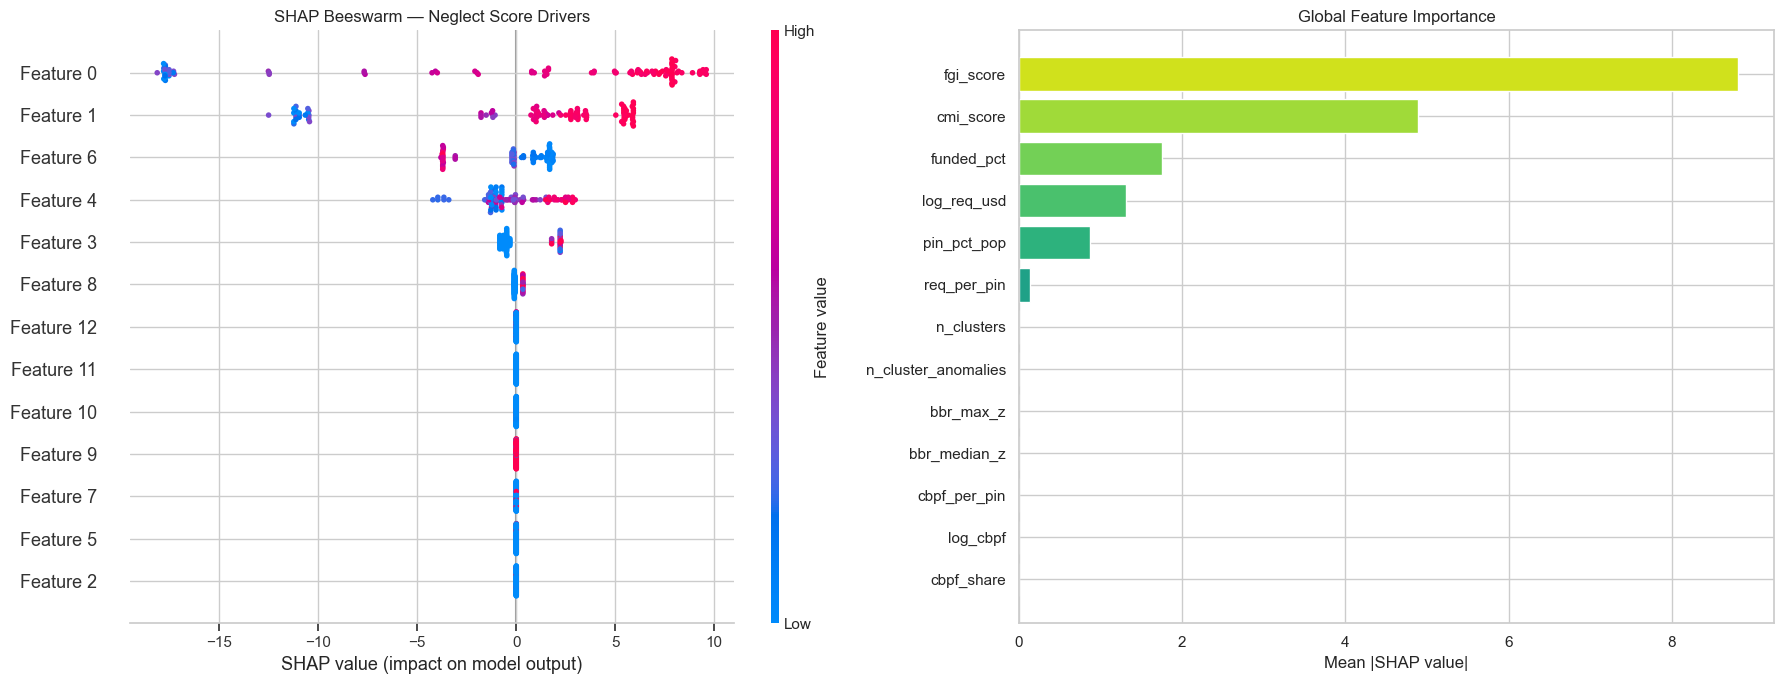

Top SHAP driver by country (top 15 neglected):
country_iso3  neglect_score top_driver
         NGA           76.3  fgi_score
         YEM           76.3  fgi_score
         SSD           75.0  fgi_score
         COD           75.0  fgi_score
         AFG           74.8  fgi_score
         HTI           73.8  fgi_score
         VEN           73.8  fgi_score
         BFA           73.7  fgi_score
         MLI           73.7  fgi_score
         MMR           73.4  fgi_score
         TCD           73.0  fgi_score
         SYR           71.3  fgi_score
         BGD           70.7  fgi_score
         TUR           70.7  fgi_score
         UKR           70.7  fgi_score


In [7]:
explainer   = shap.TreeExplainer(model)
shap_values = explainer(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
plt.sca(axes[0])
shap.plots.beeswarm(shap_values, max_display=13, show=False, plot_size=None)
axes[0].set_title("SHAP Beeswarm — Neglect Score Drivers")

mean_abs = np.abs(shap_values.values).mean(axis=0)
feat_imp = pd.Series(mean_abs, index=FEATURE_COLS).sort_values()
axes[1].barh(feat_imp.index, feat_imp.values, color=sns.color_palette("viridis", len(feat_imp)))
axes[1].set_xlabel("Mean |SHAP value|")
axes[1].set_title("Global Feature Importance")
plt.tight_layout(); plt.show()

shap_df = pd.DataFrame(shap_values.values, columns=FEATURE_COLS)
shap_df["country_iso3"]   = feat["country_iso3"].values
shap_df["neglect_score"]  = feat["predicted_neglect"].values
shap_df["top_driver"]     = shap_df.set_index("country_iso3")[FEATURE_COLS].abs().idxmax(axis=1).values
shap_driver_map = dict(zip(shap_df["country_iso3"], shap_df["top_driver"]))

print("Top SHAP driver by country (top 15 neglected):")
print(shap_df.sort_values("neglect_score", ascending=False).head(15)[["country_iso3", "neglect_score", "top_driver"]].to_string(index=False))

---
## KNN Peer Countries & Final Visualisation

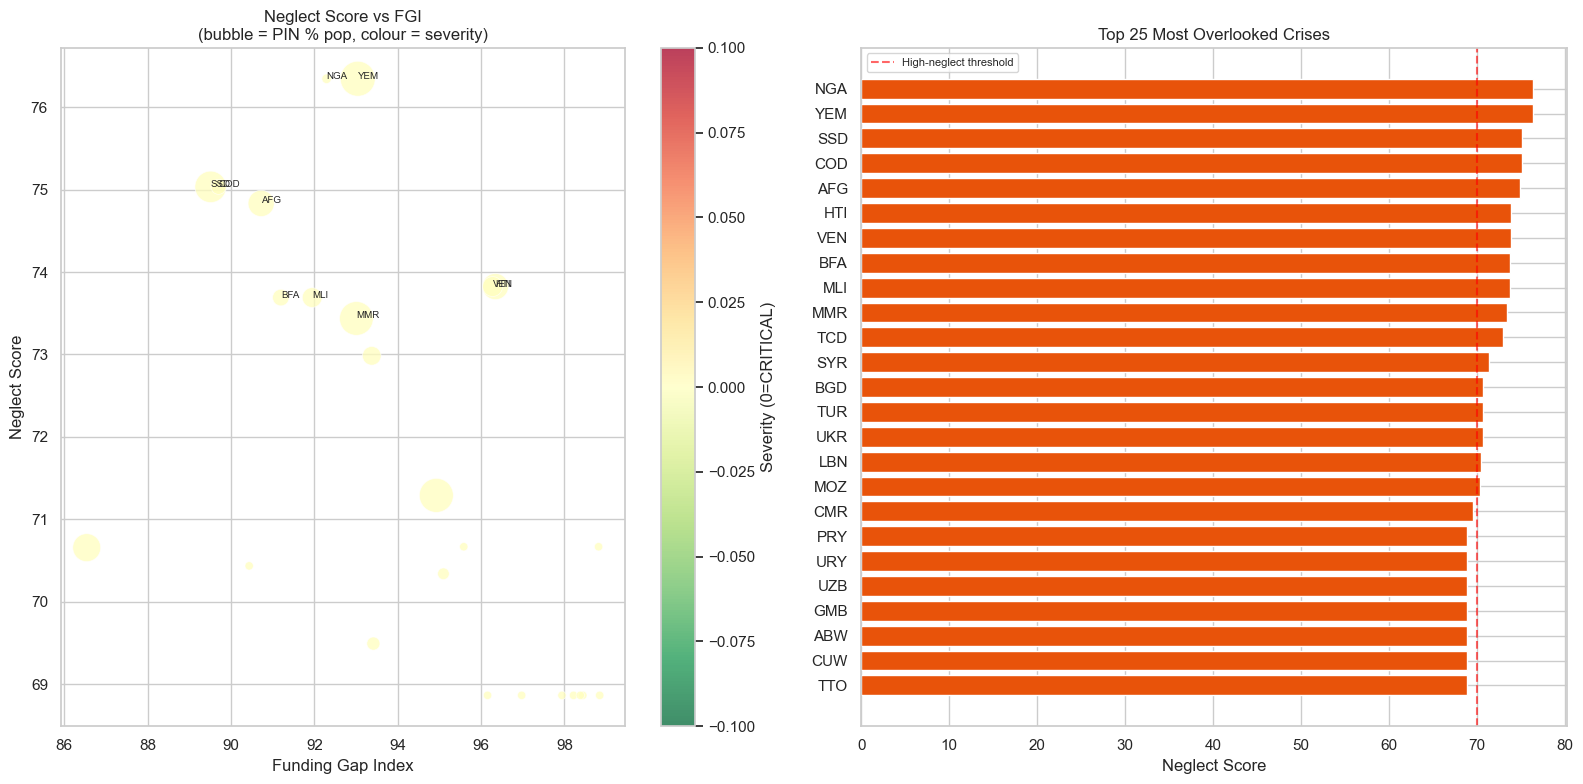

In [8]:
knn = NearestNeighbors(n_neighbors=6, metric="cosine")
knn.fit(X_scaled)
_, indices = knn.kneighbors(X_scaled)
iso3_list = feat["country_iso3"].tolist()
peer_map  = {iso3_list[i]: [iso3_list[j] for j in indices[i][1:]] for i in range(len(iso3_list))}
feat["peer_iso3"] = feat["country_iso3"].map(peer_map)

top25 = feat.sort_values("predicted_neglect", ascending=False).head(25).copy()
SEV_COLORS = {"CRITICAL": "#E8530A", "HIGH": "#FFA500", "MEDIUM": "#FFD700", "LOW": "#55A868"}
bar_colors = [SEV_COLORS.get(s, "#999") for s in top25["anomaly_severity"]]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sc = axes[0].scatter(
    top25["fgi_score"], top25["predicted_neglect"],
    c=[{"CRITICAL": 0, "HIGH": 1, "MEDIUM": 2, "LOW": 3}.get(s, 2) for s in top25["anomaly_severity"]],
    cmap="RdYlGn_r", s=top25["pin_pct_pop"].clip(1)*6+30,
    alpha=0.75, edgecolors="white", linewidths=0.5
)
for _, r in top25.head(10).iterrows():
    axes[0].annotate(r["country_iso3"], (r["fgi_score"], r["predicted_neglect"]), fontsize=7)
axes[0].set_xlabel("Funding Gap Index"); axes[0].set_ylabel("Neglect Score")
axes[0].set_title("Neglect Score vs FGI\n(bubble = PIN % pop, colour = severity)")
plt.colorbar(sc, ax=axes[0], label="Severity (0=CRITICAL)")

axes[1].barh(top25["country_iso3"][::-1], top25["predicted_neglect"][::-1], color=bar_colors[::-1])
axes[1].axvline(70, ls="--", color="red", alpha=0.6, label="High-neglect threshold")
axes[1].set_xlabel("Neglect Score"); axes[1].set_title("Top 25 Most Overlooked Crises")
axes[1].legend(fontsize=8)
plt.tight_layout(); plt.show()

In [9]:
MODELS_DIR = pathlib.Path(os.getcwd()) if pathlib.Path(os.getcwd()).name == "models" else pathlib.Path(os.getcwd()) / "models"
MODELS_DIR.mkdir(exist_ok=True)

joblib.dump(model,  MODELS_DIR / "lgbm_neglect.pkl")
joblib.dump(scaler, MODELS_DIR / "scaler.pkl")
with open(MODELS_DIR / "feature_names.json", "w") as f:
    json.dump(FEATURE_COLS, f, indent=2)

# Per-country cluster breakdown
cluster_bb = (
    gold_efficiency.groupby(["country_iso3", "cluster_name"])
    .agg(bbr=("bbr", "mean"), bbr_z_score=("bbr_z_score", "mean")).reset_index()
)
cluster_bb_map = (
    cluster_bb.groupby("country_iso3")
    .apply(lambda g: g[["cluster_name", "bbr", "bbr_z_score"]].to_dict("records")).to_dict()
)

# Funding trend per country
annual_country = (
    fts_req.dropna(subset=["req_usd", "funded_usd", "country_iso3"]).query("req_usd > 0")
    .groupby(["country_iso3", "year"])[["req_usd", "funded_usd"]].sum().reset_index()
)
annual_country_map = (
    annual_country.groupby("country_iso3")
    .apply(lambda g: g[["year", "req_usd", "funded_usd"]].sort_values("year").to_dict("records")).to_dict()
)

records = []
for _, row in feat.iterrows():
    iso = row["country_iso3"]
    records.append({
        "iso3":           iso,
        "neglectScore":   round(float(row["predicted_neglect"]), 2),
        "fgiScore":       round(float(row["fgi_score"]), 2),
        "cmiScore":       round(float(row["cmi_score"]), 2),
        "cbpfTotalUsd":   round(float(row["cbpf_total_usd"]), 0),
        "cbpfShare":      round(float(row["cbpf_share"]), 4),
        "pinPctPop":      round(float(row["pin_pct_pop"]), 2),
        "anomalySeverity": str(row["anomaly_severity"]),
        "neglectFlag":    bool(row["predicted_neglect"] >= 65),
        "topShapDriver":  shap_driver_map.get(iso, "fgi_score"),
        "peerIso3":       peer_map.get(iso, []),
        "clusterBreakdown": cluster_bb_map.get(iso, []),
        "fundingTrend":   annual_country_map.get(iso, []),
        "reqUsd":         round(float(row["req_usd"]), 0),
        "fundedUsd":      round(float(row["funded_usd"]), 0),
        "pin":            round(float(row["pin"]), 0),
        "planName":       str(row.get("plan_name", "")),
        "latestYear":     int(row.get("year", 0)) if pd.notna(row.get("year")) else 0,
    })

gold_path = MODELS_DIR / "gold_country_scores.json"
with open(gold_path, "w") as f:
    json.dump(records, f, indent=2, default=str)

print(f"Saved  lgbm_neglect.pkl  scaler.pkl  feature_names.json")
print(f"Saved  gold_country_scores.json  ({len(records)} countries)")
print(f"Neglect-flagged (score≥65): {sum(r['neglectFlag'] for r in records)}")
print(f"CRITICAL anomaly:           {sum(1 for r in records if r['anomalySeverity']=='CRITICAL')}")

Saved  lgbm_neglect.pkl  scaler.pkl  feature_names.json
Saved  gold_country_scores.json  (103 countries)
Neglect-flagged (score≥65): 46
CRITICAL anomaly:           54
